In [157]:
!rm /root/.cache/matplotlib/fontlist-v310.json

rm: cannot remove '/root/.cache/matplotlib/fontlist-v310.json': No such file or directory


In [158]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [159]:
!pip install japanize_matplotlib

In [0]:
#必要なモジュール
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import networkx as nx

In [0]:
#csvファイルからpandsa形式のテーブルを作成
station = pd.read_csv("station20200316free.csv")
join = pd.read_csv("join20200306.csv")
pref = pd.read_csv("pref.csv")
line = pd.read_csv("line20200306free.csv")
company = ("company20200309.csv")

In [199]:
station.head()

,station_cd,station_g_cd,station_name,station_name_k,station_name_r,line_cd,pref_cd,post,address,lon,lat,open_ymd,close_ymd,e_status,e_sort
0,1110101,1110101,函館,NaN,NaN,11101,1,040-0063,北海道函館市若松町１２-１３,140.726413,41.773709,1902-12-10,0000-00-00,0,1110101
1,1110102,1110102,五稜郭,NaN,NaN,11101,1,041-0813,函館市亀田本町,140.733539,41.803557,0000-00-00,0000-00-00,0,1110102
2,1110103,1110103,桔梗,NaN,NaN,11101,1,041-0801,北海道函館市桔梗３丁目４１-３６,140.722952,41.846457,1902-12-10,0000-00-00,0,1110103
3,1110104,1110104,大中山,NaN,NaN,11101,1,041-1121,亀田郡七飯町大字大中山,140.713580,41.864641,0000-00-00,0000-00-00,0,1110104
4,1110105,1110105,七飯,NaN,NaN,11101,1,041-1111,亀田郡七飯町字本町,140.688556,41.886971,0000-00-00,0000-00-00,0,1110105


In [200]:
join.head()

,line_cd,station_cd1,station_cd2
0,1002,100201,100202
1,1002,100202,100203
2,1002,100203,100204
3,1002,100204,100205
4,1002,100205,100206


In [0]:
"""
全国の路線を考える前に、小規模の問題として東京メトロの路線を抽出し、作成する
"""
#全国の駅から東京メトロの駅のみ抽出する 東京メトロ...company_cd == 18
metro = station[["station_cd", "station_name", "line_cd", "lon", "lat"]]
metro = pd.merge(metro, line, on = 'line_cd')
metro = metro[metro["company_cd"] == 18]
metro = metro[["station_cd", "station_name", "line_cd", "lon_x", "lat_x", "line_name", "line_color_c", "line_color_t"]]
lon = metro["lon_x"]
lat = metro["lat_x"]
metro["lon"] = lon
metro["lat"] = lat
metro = metro[["station_cd", "station_name", "line_cd", "lon", "lat", "line_name"]]

#東京メトロの接続辺を抽出する 路線...line_cd == 28001---28010
metro_join = join[(join["line_cd"]==28001)|(join["line_cd"]==28002)|(join["line_cd"]==28003)|(join["line_cd"]==28004)|(join["line_cd"]==28005)|(join["line_cd"]==28006)|(join["line_cd"]==28007)|(join["line_cd"]==28008)|(join["line_cd"]==28009)|(join["line_cd"]==28010)]
metro_join = metro_join[["station_cd1", "station_cd2"]]

In [201]:
metro.head()

,station_cd,station_name,line_cd,lon,lat,line_name
5816,2800101,浅草,28001,139.797592,35.710733,東京メトロ銀座線
5817,2800102,田原町,28001,139.790897,35.709897,東京メトロ銀座線
5818,2800103,稲荷町,28001,139.782593,35.711273,東京メトロ銀座線
5819,2800104,上野,28001,139.777122,35.711482,東京メトロ銀座線
5820,2800105,上野広小路,28001,139.772877,35.707680,東京メトロ銀座線


In [202]:
join.head()

,line_cd,station_cd1,station_cd2
0,1002,100201,100202
1,1002,100202,100203
2,1002,100203,100204
3,1002,100204,100205
4,1002,100205,100206


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


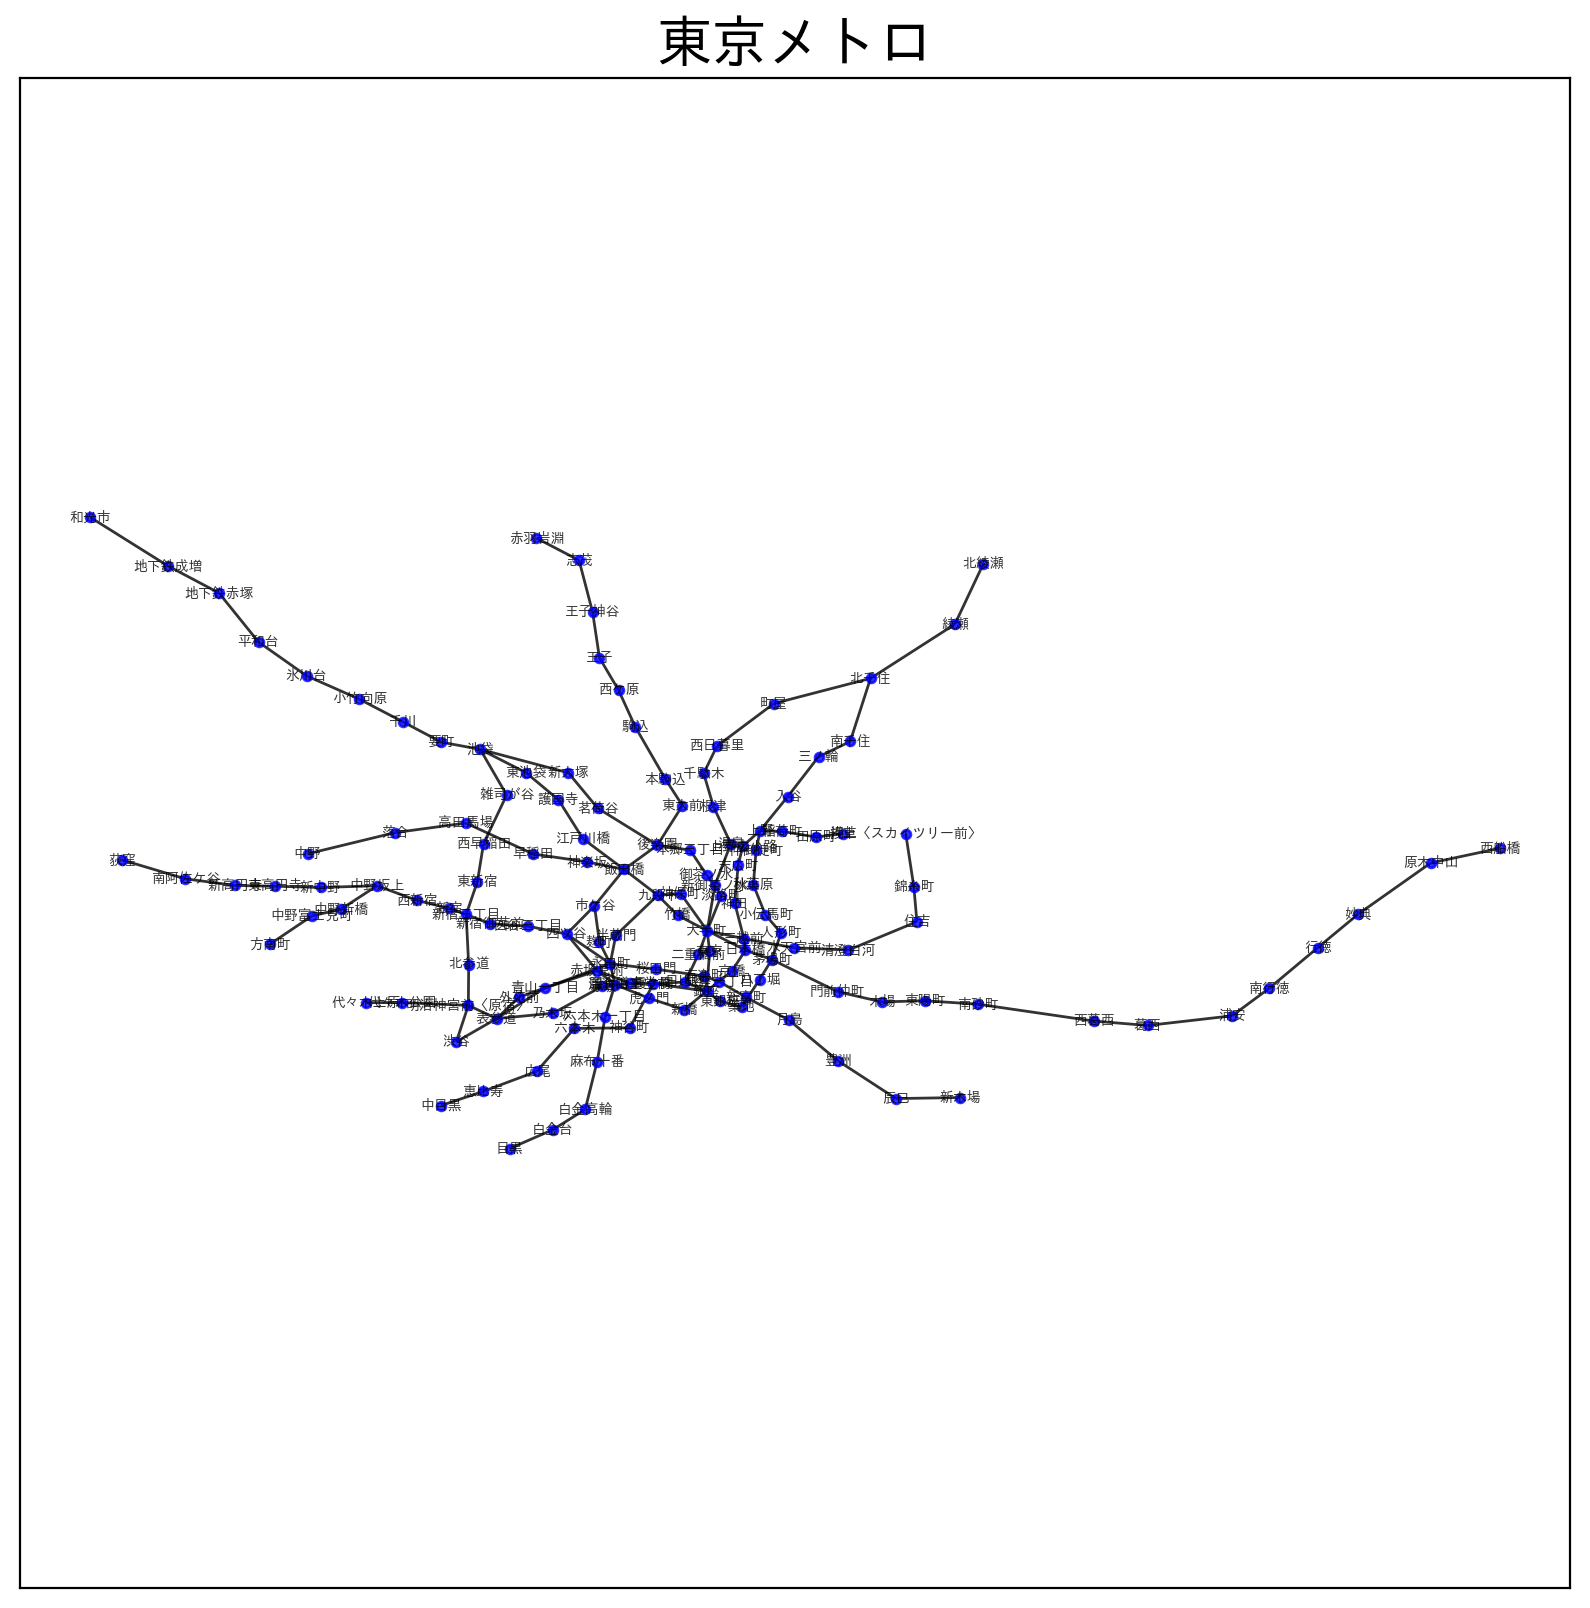

In [179]:
#グラフの宣言
G = nx.Graph()
#頂点を駅名にする
G.add_nodes_from(metro["station_name"])
#plotの座標を設定
pos={}
for i, j, k in zip(metro["station_name"], metro["lon"], metro["lat"]):
  pos[i] = (j, k)
#リストeにstation_nameとstation_cdを格納し、リンクさせる
e = []
for i, j in zip(metro["station_name"], metro["station_cd"]):
  e.append([i, j])
#グラフに辺情報を加える
for i, j in zip(metro_join["station_cd1"], metro_join["station_cd2"]):
    for k in e:
      if k[1] == i:
        for l in e:
          if l[1] == j:
            G.add_edge(k[0], l[0])
#グラフの出力の設定
plt.figure(figsize=(10,10),dpi=200)
plt.title('東京メトロ', fontsize=20)
plt.axes().set_aspect('equal', 'datalim')
nx.draw_networkx(G, pos, node_color='b', alpha=0.8, node_size=10, font_size=5, font_family='IPAexGothic')
plt.show()

In [0]:
#辺に重みとして駅間の距離を持たせるためのデータ作成
dist = []
cd1_lat = []
cd1_lon = []
cd2_lat = []
cd2_lon = []
not_exist = [] #joinテーブルには存在しているが、stationテーブルには存在していないstation_cdを格納
for i, j in zip(metro_join["station_cd1"], metro_join["station_cd2"]):
  flag = True
  for k, l, m in zip(metro["station_cd"], metro["lat"], metro["lon"]):
    if i == k:
      cd1_x = l
      cd1_y = m
      cd1_lat.append(l)
      cd1_lon.append(m)
      flag = False
    if j == k:
      cd2_x = l
      cd2_y = m
      cd2_lat.append(l)
      cd2_lon.append(m)
  if flag:
    not_exist.append([i, j])
    #print(i, j)
  else:
    dist.append(((cd1_x-cd2_x)**2 + (cd1_y-cd2_y)**2)**0.5)
#このまま実行するとエラー ValueError: Length of values does not match length of index
#どうやら"station_cd" == 2800701と2800702はstationテーブルに存在しておらず、joinテーブルから不要なので削除
#以下2行は...metro_join = metro_join[metro_join["station_cd1"] != 2800701]...と等価
for i in range(len(not_exist)):
  metro_join = metro_join[metro_join["station_cd1"] != not_exist[i][0]]
#joinテーブルに列を追加
metro_join["cd1_lat"] = cd1_lat
metro_join["cd1_lon"] = cd1_lon
metro_join["cd2_lat"] = cd2_lat
metro_join["cd2_lon"] = cd2_lon
metro_join["distance"] = dist

In [0]:
#nodes is station_name
#グラフに辺の重みを与える
for i, j, m in zip(metro_join["station_cd1"], metro_join["station_cd2"], metro_join["distance"]):
    for k in e:
      if k[1] == i:
        for l in e:
          if l[1] == j:
            G.add_edge(k[0], l[0], weight=m)

In [0]:
#nodes is station_cd
#最短経路問題を解くために必要なNetworkXのライブラリ、Networkx.dijkstra_path()は日本語の頂点に対応していないようです。頂点をstation_nameからstation_cdへ変更し、新たにグラフを宣言します。
G = nx.Graph()
G.add_nodes_from(metro["station_cd"])
pos={}
for i, j, k in zip(metro["station_cd"], metro["lon"], metro["lat"]):
  pos[i] = (j, k)
for i, j, m in zip(metro_join["station_cd1"], metro_join["station_cd2"], metro_join["distance"]):
  G.add_edge(i, j, weight=m)
#station_cdを頂点にしたときに、同名のstation_nameでも路線ごとにstation_cdが設定されているため、このままでは他の路線との接続辺を持っていない
#そこで、重み0として同名の駅を接続させる
for i, j in zip(metro["station_name"], metro["station_cd"]):
  for k, l in zip(metro["station_name"], metro["station_cd"]):
    if i == k and j != l:
      G.add_edge(j, l, weight=0)

['荻窪', '南阿佐ケ谷', '新高円寺', '東高円寺', '新中野', '中野坂上', '西新宿', '新宿', '新宿三丁目', '新宿御苑前', '四谷三丁目', '四ツ谷', '赤坂見附', '国会議事堂前', '国会議事堂前', '霞ケ関', '日比谷', '日比谷', '銀座', '銀座', '京橋', '日本橋', '日本橋', '茅場町', '門前仲町', '木場', '東陽町', '南砂町', '西葛西', '葛西', '浦安', '南行徳', '行徳', '妙典', '原木中山', '西船橋']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


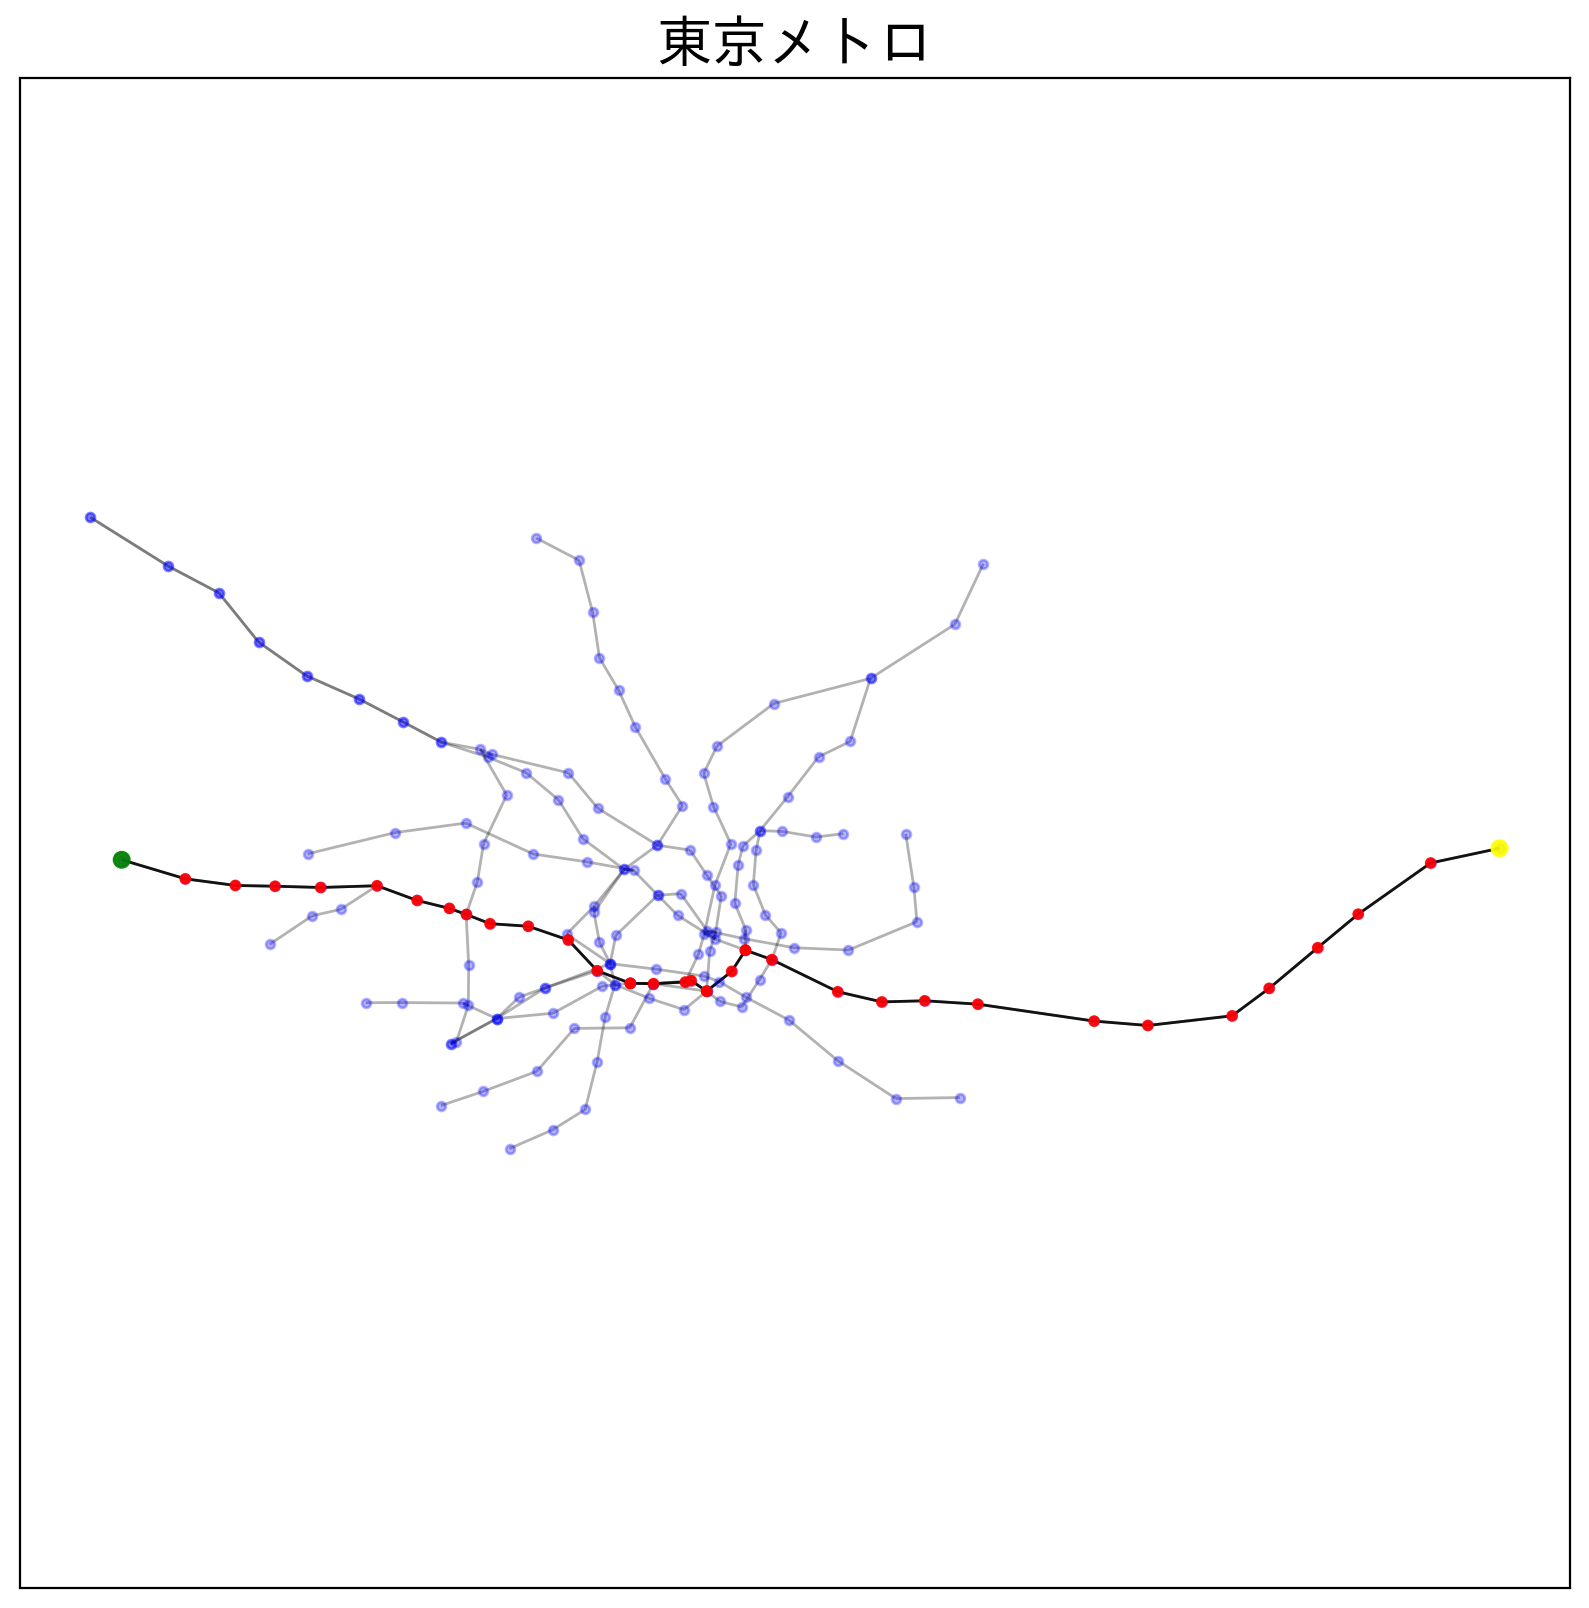

In [192]:
#スタートとゴールの駅を設定
st_name = "荻窪"
go_name = "西船橋"
#station_nameからstation_cdを検索
for i, j in zip(metro["station_name"], metro["station_cd"]):
  if i == st_name:
    st = j
  if i == go_name:
    go = j
#最短経路を探索
dij = nx.dijkstra_path(G, st, go)
out = []
for k in range(len(dij)):
  for i, j in zip(metro["station_name"], metro["station_cd"]):
    if j == dij[k]:
      out.append(i)
print(out)
#最短経路用のグラフを宣言
G_root = nx.Graph()
G_root.add_nodes_from(dij)
pos_root = {}
for l in dij:
  for i, j, k in zip(metro["station_cd"], metro["lon"], metro["lat"]):
    if l == i:
      pos_root[l] = (j, k)
for i in range(len(dij)-1):
  G_root.add_edge(dij[i], dij[i+1])

plt.figure(figsize=(10,10),dpi=200)
plt.title('東京メトロ', fontsize=20)
plt.axes().set_aspect('equal', 'datalim')
nx.draw_networkx(G, pos, node_color='b', alpha=0.3, node_size=10, with_labels= False)
c = ['green' if n==st else 'red' if n!=go else'yellow' for n in G_root.nodes()]
n_size = [30 if n==st else 10 if n!=go else 30 for n in G_root.nodes()]
nx.draw_networkx(G_root, pos_root, node_color=c, alpha=0.9, node_size=n_size, with_labels= False)
plt.show()

In [0]:
zen_join = join

In [0]:
zen = station[["station_cd", "station_name", "line_cd", "lon", "lat"]]
zen = pd.merge(zen, line, on='line_cd')
zen = zen[["station_cd", "station_name", "line_cd", "lon_x", "lat_x", "line_name"]]
lon = zen["lon_x"]
lat = zen["lat_x"]
zen["lon"] = lon
zen["lat"] = lat
zen = zen[["station_cd", "station_name", "line_cd", "lon", "lat", "line_name"]]

In [0]:
cd1_lat = []
cd1_lon = []
cd2_lat = []
cd2_lon = []
dist = []
not_exist = []
for i, j in zip(zen_join["station_cd1"], zen_join["station_cd2"]):
  flag = True
  for k, l, m in zip(zen["station_cd"], zen["lat"], zen["lon"]):
    if i == k:
      cd1_x = l
      cd1_y = m
      cd1_lat.append(l)
      cd1_lon.append(m)
      flag = False
    if j == k:
      cd2_x = l
      cd2_y = m
      cd2_lat.append(l)
      cd2_lon.append(m)
  if flag:
    not_exist.append([i, j])
    #print(i, j)
  else:
    dist.append(((cd1_x-cd2_x)**2 + (cd1_y-cd2_y)**2)**0.5)
#stationテーブルに存在しておらず、joinテーブルから不要なので削除
for i in range(len(not_exist)):
  zen_join = zen_join[zen_join["station_cd1"] != not_exist[i][0]]# & zen_join["station_cd2"] != not_exist[i][1]]
zen_join["cd1_lat"] = cd1_lat
zen_join["cd1_lon"] = cd1_lon
zen_join["cd2_lat"] = cd2_lat
zen_join["cd2_lon"] = cd2_lon
zen_join["distance"] = dist

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


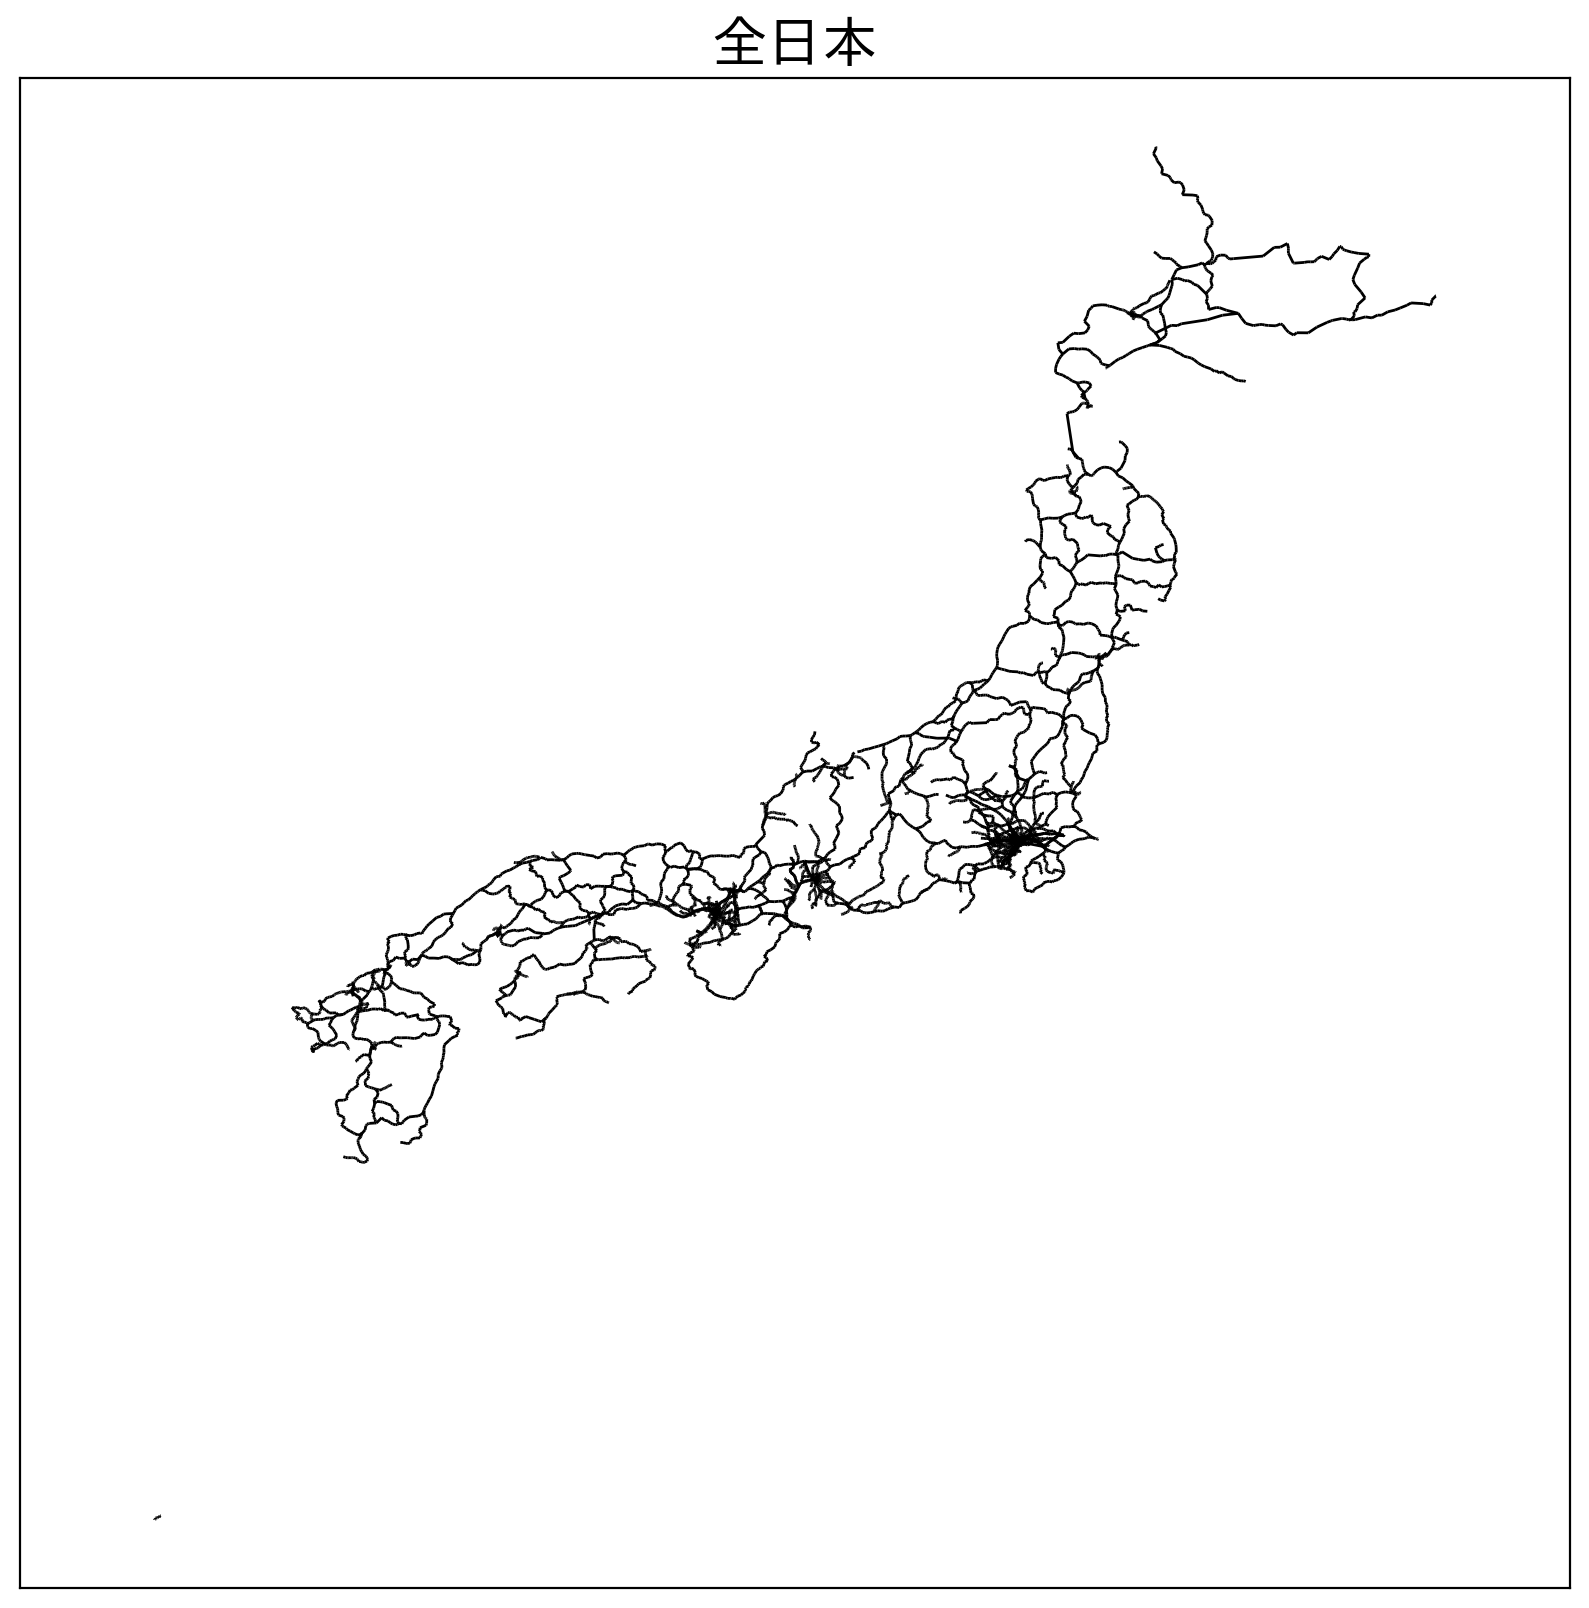

In [196]:
#nodes is station_cd
G = nx.Graph()
G.add_nodes_from(zen["station_cd"])
pos={}
for i, j, k in zip(zen["station_cd"], zen["lon"], zen["lat"]):
  pos[i] = (j, k)
for i, j, m in zip(zen_join["station_cd1"], zen_join["station_cd2"], zen_join["distance"]):
  G.add_edge(i, j, weight=m)
for i, j, m in zip(zen["station_name"], zen["station_cd"], zen["lat"]):
  for k, l, n in zip(zen["station_name"], zen["station_cd"], zen["lat"]):
    if i == k and j != l and m == n:
      #print(i, j, k, l)
      G.add_edge(j, l, weight=0)
plt.figure(figsize=(10,10),dpi=200)
plt.title('全日本', fontsize=20)
plt.axes().set_aspect('equal', 'datalim')
nx.draw_networkx(G, pos, alpha=0.0, with_labels=False)
nx.draw_networkx_edges(G, pos)
plt.show()

['根室', '東根室', '西和田', '昆布盛', '落石', '別当賀', '厚床', '姉別', '浜中', '茶内', '糸魚沢', '厚岸', '門静', '尾幌', '上尾幌', '別保', '武佐', '東釧路', '釧路', '釧路', '新富士', '新大楽毛', '大楽毛', '庶路', '西庶路', '白糠', '音別', '厚内', '浦幌', '新吉野', '豊頃', '十弗', '池田', '利別', '幕別', '札内', '帯広', '柏林台', '西帯広', '大成', '芽室', '御影', '十勝清水', '新得', '新得', 'トマム', '占冠', '新夕張', '滝ノ上', '川端', '追分', '追分', '安平', '早来', '遠浅', '沼ノ端', '苫小牧', '苫小牧', '青葉', '糸井', '錦岡', '社台', '白老', '萩野', '北吉原', '竹浦', '虎杖浜', '登別', '富浦', '幌別', '鷲別', '東室蘭', '本輪西', '崎守', '黄金', '稀府', '北舟岡', '伊達紋別', '長和', '有珠', '洞爺', '豊浦', '大岸', '礼文', '小幌', '静狩', '長万部', '長万部', '中ノ沢', '国縫', '黒岩', '山崎', '八雲', '山越', '野田生', '落部', '石倉', '本石倉', '石谷', '森', '駒ケ岳', '赤井川', '大沼公園', '大沼', '七飯', '大中山', '桔梗', '五稜郭', '五稜郭', '七重浜', '東久根別', '久根別', '清川口', '上磯', '茂辺地', '渡島当別', '釜谷', '泉沢', '札苅', '木古内', '木古内', '津軽今別', '中小国', '中小国', '蟹田', '瀬辺地', '郷沢', '蓬田', '中沢', '後潟', '左堰', '奥内', '津軽宮田', '油川', '青森', '青森', '新青森', '津軽新城', '鶴ケ坂', '大釈迦', '浪岡', '北常盤', '川部', '撫牛子', '弘前', '石川', '大鰐温泉', '長峰', '碇ケ関', '津軽湯の沢', '陣場', '白沢', '大館', '下川沿', '早口

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 10000x10000 with 0 Axes>

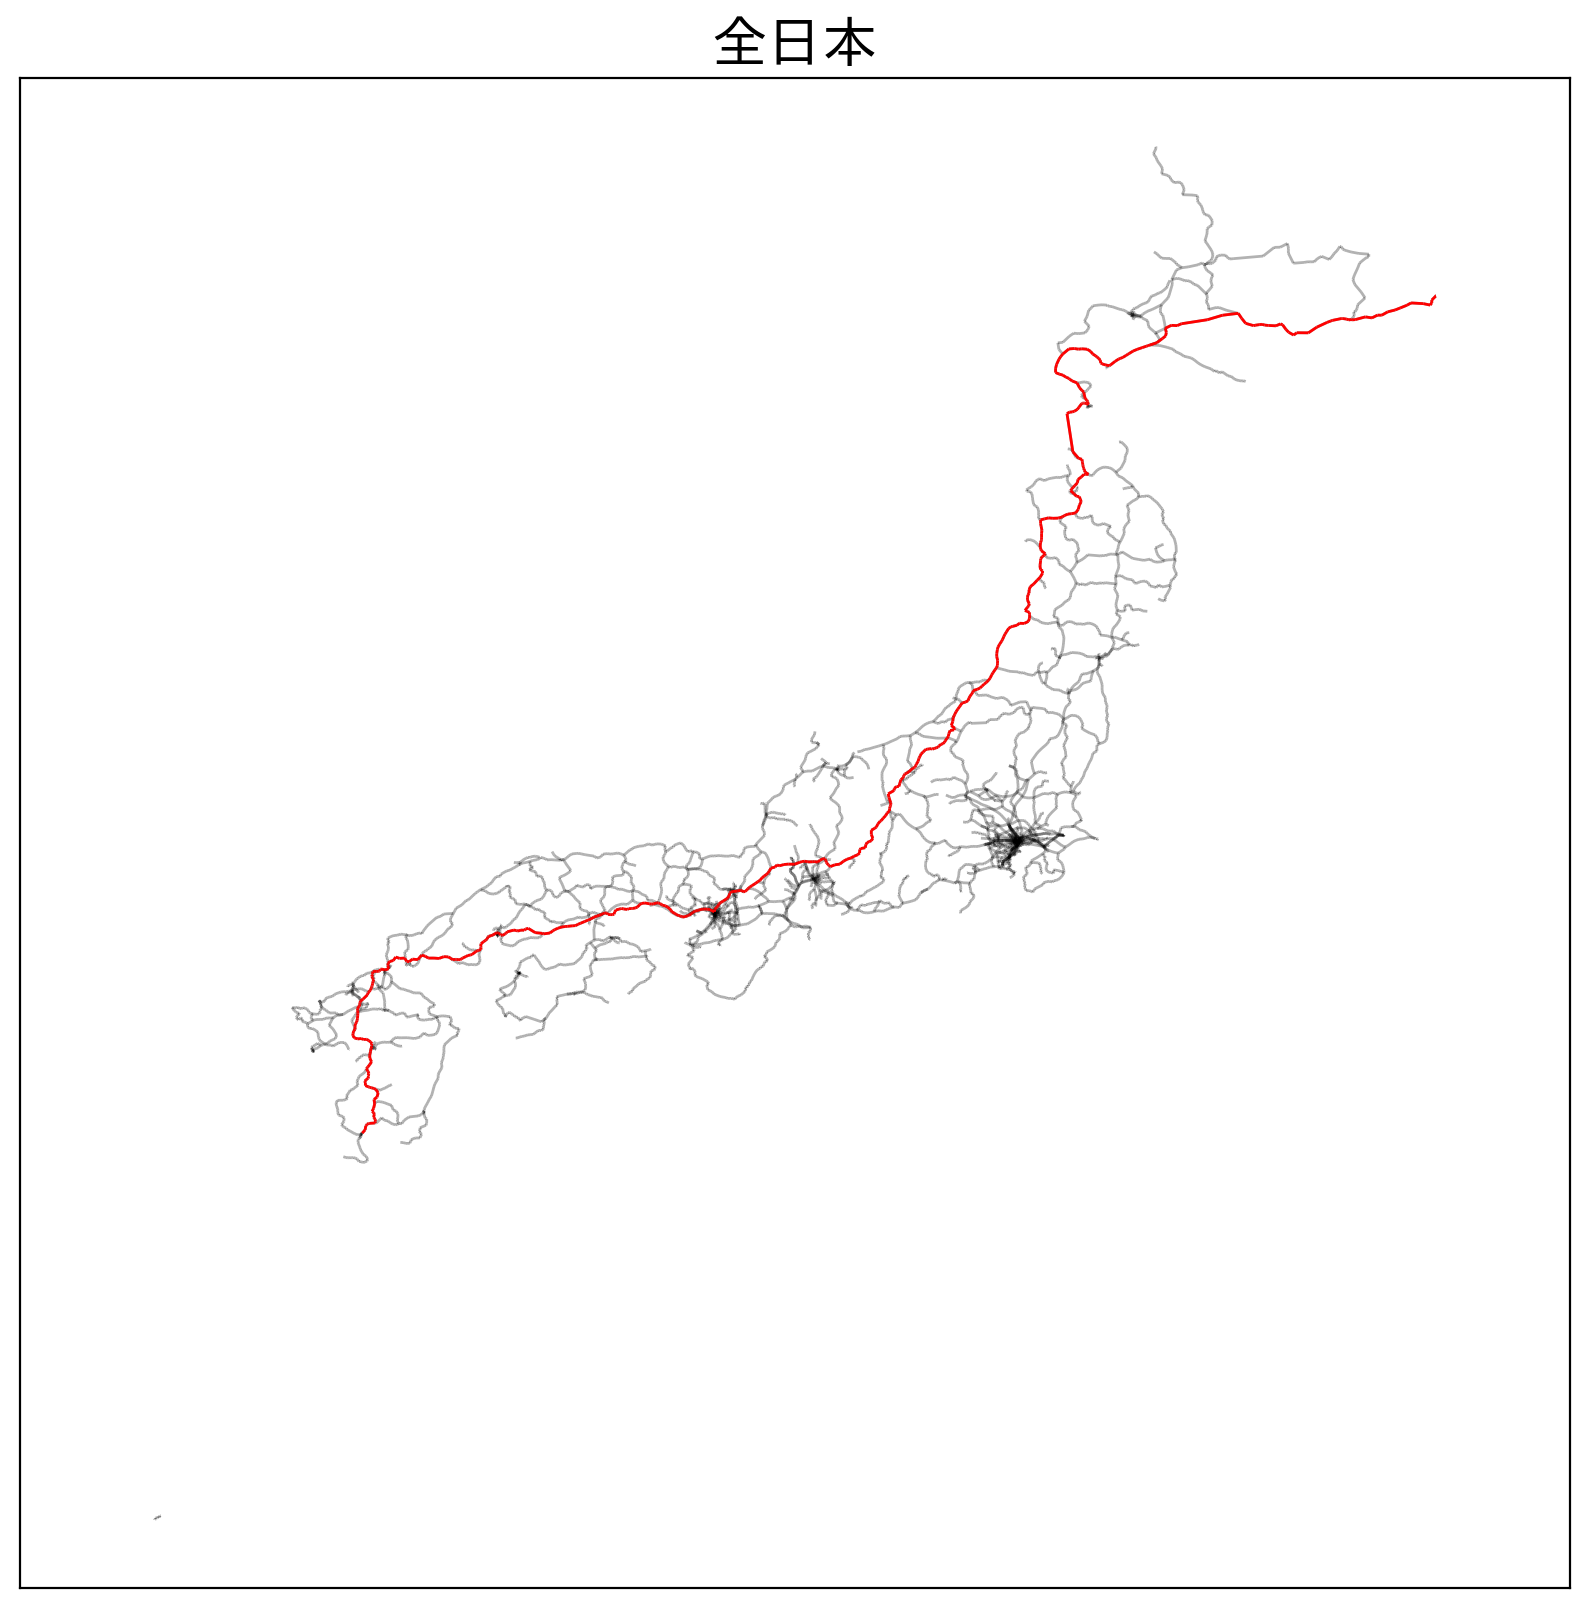

In [197]:
st_name = "根室"
go_name = "鹿児島"
for i, j in zip(zen["station_name"], zen["station_cd"]):
  if i == st_name:
    st = j
  if i == go_name:
    go = j
dij = nx.dijkstra_path(G, st, go)
out = []
for k in range(len(dij)):
  for i, j in zip(zen["station_name"], zen["station_cd"]):
    if j == dij[k]:
      out.append(i)
print(out)

#nodes is station_cd
plt.figure(figsize=(50,50),dpi=200)
G_root = nx.Graph()
G_root.add_nodes_from(dij)
pos_root = {}
for l in dij:
  for i, j, k in zip(zen["station_cd"], zen["lon"], zen["lat"]):
    if l == i:
      pos_root[l] = (j, k)
for i in range(len(dij)-1):
  G_root.add_edge(dij[i], dij[i+1])

plt.figure(figsize=(10,10),dpi=200)
plt.title('全日本', fontsize=20)
plt.axes().set_aspect('equal', 'datalim')
nx.draw_networkx(G, pos, alpha=0.0, with_labels=False)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx(G_root, pos_root, alpha=0.0, with_labels=False)
nx.draw_networkx_edges(G_root, pos_root, alpha=1.0, edge_color='r')
plt.show()